# Decision Making under Uncertainty - P1

Group members
- Mohammad Beigi
- Sagar Parekh

## Goal

explain the goal in a small paragraph

## Import Necessary Packages and Load the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pgmpy.estimators import BDeuScore, BicScore
from pgmpy.estimators import HillClimbSearch, BayesianEstimator
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork
from pgmpy.metrics import correlation_score
import graphviz

import torch
import torch.nn as nn
import torch.utils.data as data_utils
from tqdm import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


In [2]:
raw_data = pd.read_csv('heart.csv')
raw_data.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Analyzing the Data

#### Class Distribution
We check the data for class imbalance.

<BarContainer object of 2 artists>

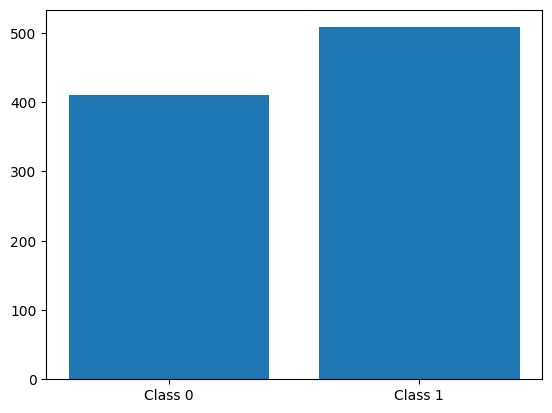

In [3]:
[num_1, num_0] = raw_data.HeartDisease.value_counts()
plt.bar(['Class 0', 'Class 1'], [num_0, num_1])


Since the dataset does not contain a balanced distribution over the two classes, we remove 100 samples from Class 1.

Length of data before trimming: 918
Length of data after trimming: 818


<BarContainer object of 2 artists>

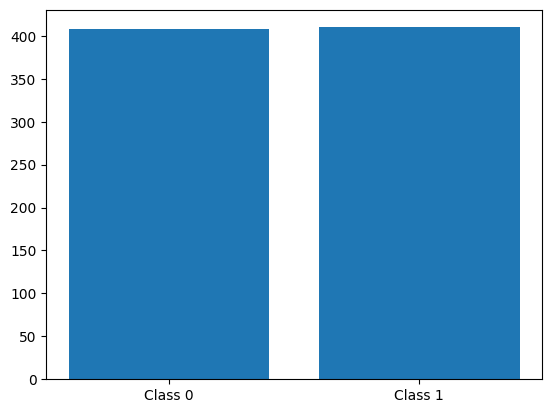

In [4]:
print('Length of data before trimming: {}'.format(len(raw_data)))

class_1 = raw_data.index[raw_data['HeartDisease'] == 1].tolist()
raw_data.drop(raw_data.index[class_1[:100]], axis=0, inplace=True)
raw_data = raw_data.reset_index()
raw_data.drop(columns='index', inplace=True)

print('Length of data after trimming: {}'.format(len(raw_data)))

[num_1, num_0] = raw_data.HeartDisease.value_counts()
plt.bar(['Class 0', 'Class 1'], [num_0, num_1])


#### Correlation between Attributes
We look at the pairwise correlation between the numeric attributes

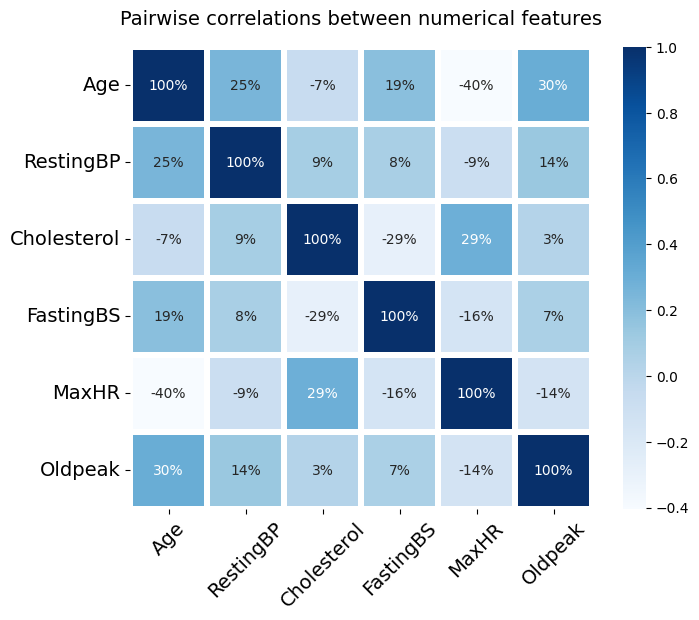

In [5]:
fig = plt.figure(figsize=(8,6))
numerical_features = list(raw_data.select_dtypes(['int', 'float']).columns[:-1])
ax = sns.heatmap(raw_data[numerical_features].corr(), annot=True, linewidths=3, square=True, cmap='Blues', fmt=".0%")

ax.set_title('Pairwise correlations between numerical features', fontsize=14, x=0.50, y=1.03);
ax.set_xticklabels(numerical_features, fontsize=14, rotation = 45)
ax.set_yticklabels(numerical_features, fontsize=14, rotation= 0);

## Processing the Data

The pgmpy package can only handle discrete data. However, some of the attributes in the dataset have continuous values.

In [6]:
print(raw_data[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']])


     Age  RestingBP  Cholesterol  MaxHR  Oldpeak
0     40        140          289    172      0.0
1     37        130          283     98      0.0
2     54        150          195    122      0.0
3     39        120          339    170      0.0
4     45        130          237    170      0.0
..   ...        ...          ...    ...      ...
813   45        110          264    132      1.2
814   68        144          193    141      3.4
815   57        130          131    115      1.2
816   57        130          236    174      0.0
817   38        138          175    173      0.0

[818 rows x 5 columns]


We find the range of the values of these attributes

In [7]:
print('Age range: {} - {}'.format(raw_data.Age.min(), raw_data.Age.max()))
print('RestingBP range: {} - {}'.format(raw_data.RestingBP.min(), raw_data.RestingBP.max()))
print('Cholestrol range: {} - {}'.format(raw_data.Cholesterol.min(), raw_data.Cholesterol.max()))
print('MaxHR range: {} - {}'.format(raw_data.MaxHR.min(), raw_data.MaxHR.max()))
print('Oldpeak range: {} - {}'.format(raw_data.Oldpeak.min(), raw_data.Oldpeak.max()))


Age range: 28 - 77
RestingBP range: 0 - 200
Cholestrol range: 0 - 564
MaxHR range: 60 - 202
Oldpeak range: -2.6 - 6.2


So, we discretize the continuous data into tiers based on the following bins (the last values in the range are inclusive, the first values are not)

    + Age varies between 28 and 77. We divide it into 3 fixed tiers:
    tier 1 - 27 to 43,
    tier 2 - 43 to 59,
    tier 3 - 59 to 77
    
    + We discretize RestingBP into 2 tiers:
    tier 1 - -1 to 100,
    tier 2 - 100 to 200
    
    + Cholesterol varies between 0 and 603. We divide it into 6 fixed tiers:
    tier 1 - -1 to 100,
    tier 2 - 100 to 200,
    tier 3 - 200 to 300,
    tier 4 - 300 to 400,
    tier 5 - 400 to 500,
    tier 6 - 500 to 564
    
    + MaxHR varies between 60 and 202. We divide it into 3 fixed tiers: 
    tier 1 - 59 to 120,
    tier 2 - 120 to 170,
    tier 3 - 170 to 202
    
    + Oldpeak varies between -2.6 and 6.2. We discretize it as the following tiers:
    tier 1 - -2.7 to 0,
    tier 2 - 0 to 2.1,
    tier 3 - 2.1 to 4.2,
    tier 4 - 4.2 to 6.2

In [8]:
boundaries = {
             'Age': np.array([[27, 43],
                              [43, 59],
                              [59, 77]]),
             'RestingBP': np.array([[-1, 100],
                                    [100, 200]]),
             'Cholesterol': np.array([[-1, 100],
                                      [100, 200],
                                      [200, 300],
                                      [300, 400],
                                      [400, 500],
                                      [500, 564]]),
             'MaxHR': np.array([[59, 120],
                                [120, 170],
                                [170, 202]]),
             'Oldpeak': np.array([[-2.7, 0],
                                  [0, 2.1],
                                  [2.1, 4.2],
                                  [4.2, 6.2]])
             }

def discretize(series, boundaries):
    tiers = [1, 2, 3, 4, 5, 6]
    
    new_series = series.copy()
    for idx, elem in enumerate(series):
        for i in range(len(boundaries)):
            if elem > boundaries[i, 0] and elem <= boundaries[i, 1]:
                new_series.at[idx] = tiers[i]
    
    return new_series
    
new_columns = {}
for i, content in enumerate(raw_data.copy().items()):

    (label, series) = content
    
    if label in ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']:
        new_columns[label] = discretize(series, boundaries[label])
    else:
        new_columns[label] = series.copy()

data = pd.DataFrame(new_columns)
data.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,1,M,ATA,2,3,0,Normal,3,N,1.0,Up,0
1,1,M,ATA,2,3,0,ST,1,N,1.0,Up,0
2,2,M,NAP,2,2,0,Normal,2,N,1.0,Up,0
3,1,M,NAP,2,4,0,Normal,2,N,1.0,Up,0
4,2,F,ATA,2,3,0,Normal,2,N,1.0,Up,0


Split the dataset into train and test data

In [9]:
train, test = train_test_split(data.copy(), test_size=0.2)

train = train.reset_index()
train.drop('index', axis=1, inplace=True)
test = test.reset_index()
test.drop('index', axis=1, inplace=True)

true_labels = test.HeartDisease.copy()
test.drop('HeartDisease', axis=1, inplace=True)

print('Size of training data: ', train.shape)
print('Size of test data: ', test.shape)


Size of training data:  (654, 12)
Size of test data:  (164, 11)


## Learning BN from Data
We learn the structure of a BN from the given dataset. For this, we perform score-based structure learning. The score-based approach first defines a criterion to evaluate how well the Bayesian network fits the data, then searches over the space of DAGs for a structure achieving the maximal score. Here, we use the Bayesian Dirichlet scores as the criterion and use hill climb or gradient ascent method to search the space for optimal score.

In [10]:
scoring = BDeuScore(train)
hc = HillClimbSearch(train)
best_model = hc.estimate(scoring_method=scoring, max_indegree=4, max_iter=int(1e4))

print('Nodes: ', best_model.nodes())
print('Edges: ', best_model.edges())


  0%|          | 0/10000 [00:00<?, ?it/s]

Nodes:  ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']
Edges:  [('Age', 'MaxHR'), ('Cholesterol', 'RestingECG'), ('Cholesterol', 'Sex'), ('Cholesterol', 'RestingBP'), ('FastingBS', 'HeartDisease'), ('FastingBS', 'Cholesterol'), ('ExerciseAngina', 'HeartDisease'), ('ExerciseAngina', 'ChestPainType'), ('ExerciseAngina', 'ST_Slope'), ('Oldpeak', 'Age'), ('ST_Slope', 'Oldpeak'), ('HeartDisease', 'ST_Slope'), ('HeartDisease', 'ChestPainType'), ('HeartDisease', 'Cholesterol'), ('HeartDisease', 'MaxHR'), ('HeartDisease', 'Age'), ('HeartDisease', 'Sex'), ('HeartDisease', 'Oldpeak')]


#### Visualize the Learned BN

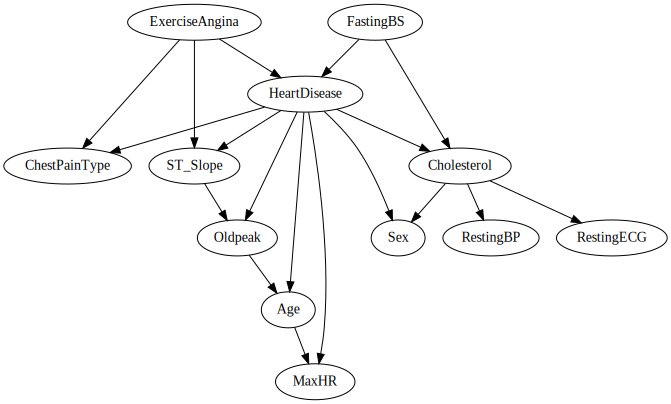

In [11]:
bn_hc = graphviz.Digraph('Learned Bayesian Network', comment='BN learned from data using Hill Climb Search')

for node in best_model.nodes():
    bn_hc.node(node)
    
for edge in best_model.edges():
    bn_hc.edge(edge[0], edge[1])
    
bn_hc.render(view=False)
bn_hc


#### Parameter Learning
Once we have learned the structure of the BN from the dataset, we need to learn the values of the conditional probability distributions of each attribute (or node). This is known as parameter learning. Here, we use the Bayesian Parameter Estimator which starts with already existing prior CPDs, that express our beliefs about the variables before the data was observed. Those “priors” are then updated, using the state counts from the observed data. We use Bayesian Dirichlet equivalent uniform prior for our case.

In [12]:
model_BN = BayesianNetwork(best_model.edges())
model_BN.fit(train, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=1000)


Check if the model output by the estimator has any errors. If the output is True, the model is error-free.

In [13]:
model_BN.check_model()


True

#### Validate the learned BN on the test data
After learning the BN and the associated conditional probability distributions, we validate this BN on the test dataset. We find the accuracy of the learned model which is the ration of total samples for which the HeartDisease was correctly classified.

In [14]:
predicted_labels = model_BN.predict(test, stochastic=True)


  0%|          | 0/150 [00:00<?, ?it/s]

In [15]:
pred_y = np.asarray(predicted_labels).squeeze()
true_y = np.asarray(true_labels).squeeze()

accuracy_BN = 1 - np.sum(abs(true_y - pred_y)) / len(true_y)
print('Accuracy of Bayesian Network: ', accuracy_BN)


Accuracy of Bayesian Network:  0.7682926829268293


## Analysis of the BN
We test how accurate the learn BN model is at capturing the correlation in the data. For this, we use the correlation score metric available in the pgmpy package. This function uses the d-connection/d-separation property to compare the model with variable correlations in a given dataset. For every pair of variables in the dataset, the Chi_square correlation test is done. We say that any two variables are correlated if the test’s p-value < significance_level. The same pair of variables are then tested whether they are d-connected in the network structure or not. Finally the accuracy_score is computed by using the correlation test as the true value and d-connections as predicted values.

In [16]:
correlation_score(model_BN, train, test='chi_square', significance_level=0.05, 
                  return_summary=False, score=metrics.accuracy_score)


0.7575757575757576

## Other Methods for Classification

We also explore other models for predicting HeartDisease based on the 11 attributes present in the dataset. Specifically, we use the following methods to compare with the BN model:

    + Neural Networks (NN) - This is a very commonly used approach for approximating functional relationship in data in order to perform classification. We use a simple multi-layer perceptron that inputs the values of the 11 attributes and predicts if they indicate a HeartDisease. The categorical attributes in the dataset are converted to one-hot vectors. The output is passed through a sigmoid activation function to scale it to the range [0, 1].
    
    + Decition Trees - The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.
    
    + Random Forests - A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
    
    

### Neural Networks
#### Preparing the dataset
We start by preparing the dataset. We need to convert the values into tensors as well as create one-hot vectors for categorical variables.

In [17]:
Age = torch.FloatTensor(raw_data.Age.values).unsqueeze(1)
Sex = torch.FloatTensor(pd.get_dummies(raw_data.Sex).values)
ChestPainType = torch.FloatTensor(pd.get_dummies(raw_data.ChestPainType).values)
RestingBP = torch.FloatTensor(raw_data.RestingBP.values).unsqueeze(1)
Cholesterol = torch.FloatTensor(raw_data.Cholesterol.values).unsqueeze(1)
FastingBS = torch.FloatTensor(raw_data.FastingBS.values).unsqueeze(1)
RestingECG = torch.FloatTensor(pd.get_dummies(raw_data.RestingECG).values)
MaxHR = torch.FloatTensor(raw_data.MaxHR.values).unsqueeze(1)
ExerciseAngina = torch.FloatTensor(pd.get_dummies(raw_data.ExerciseAngina).values)
Oldpeak = torch.FloatTensor(raw_data.Oldpeak.values).unsqueeze(1)
ST_slope = torch.FloatTensor(pd.get_dummies(raw_data.ST_Slope).values)
HeartDisease = torch.FloatTensor(raw_data.HeartDisease.values).unsqueeze(1)

data_new = np.concatenate((Age, Sex, ChestPainType, RestingBP, Cholesterol, 
                         FastingBS, RestingECG, MaxHR, ExerciseAngina, Oldpeak, ST_slope, HeartDisease), axis=1)
train_tensor, test_tensor = train_test_split(data_new, test_size=0.2)

train_label_tensor = torch.FloatTensor(train_tensor[:, -1])
test_label_tensor = torch.FloatTensor(test_tensor[:, -1])

train_tensor = torch.FloatTensor(train_tensor[:, :-1])
test_tensor = torch.FloatTensor(test_tensor[:, :-1])


#### Define the Neural Network Model

In [18]:
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)
        
class model(nn.Module):
    
    def __init__(self):
        super(model, self).__init__()
        self.linear1 = nn.Linear(20, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 1)
        
        self.criterion = nn.BCELoss()
        
        self.apply(weights_init_)        
    
    def forward(self, x):
        y_hat = torch.relu(self.linear1(x))
        y_hat = torch.relu(self.linear2(y_hat))
        return torch.sigmoid(self.linear3(y_hat)).squeeze()
        
    def train(self, x, y):
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        return loss


#### Train the Model

100%|█████████████████████████████████████| 500/500 [00:00<00:00, 2501.42it/s]


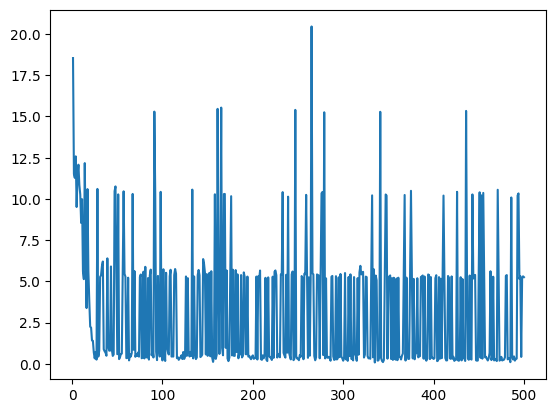

In [19]:
model_NN = model()
optimizer = torch.optim.Adam(model_NN.parameters(), lr=1e-3)
EPOCH = 500
batch_size = 20
LOSS = []

for epoch in tqdm(range(EPOCH)):
    rand_idx = np.random.randint(0, len(train_tensor), size=batch_size)
    x = train_tensor[rand_idx, :]
    y = train_label_tensor[rand_idx]
    
    loss = model_NN.train(x, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    LOSS.append(loss.item())
    
plt.plot(range(1, EPOCH+1), LOSS)
plt.show()


#### Validate the Learned Network on the Test Data
After learning the network, we validate it on the test dataset. We find the accuracy of the learned model which is the ration of total samples for which the HeartDisease was correctly classified.

In [20]:
pred_y = np.round(model_NN.forward(test_tensor).squeeze().detach().numpy())
true_y = np.asarray(test_label_tensor)

accuracy_NN = 1 - np.sum(abs(pred_y - true_y)) / len(true_y)
print('Accuracy of Neural Network: ', accuracy_NN)


Accuracy of Neural Network:  0.8231707317073171


### Decision Trees
#### Preparing the Dataset
We start by preparing the dataset. We need to divide the data into features and labels. Here, HeartDisease is the label. This is a binary classification problem where we want to predict if HeartDisease is True or False depending on the other attribute values.

In [21]:
features = data_new[:, :-1]
labels = data_new[:, -1]

train_DT, test_DT, train_label_DT, test_label_DT = train_test_split(features, labels, test_size=0.2)


#### Train the Decision Tree Classifier

In [22]:
model_DT = DecisionTreeClassifier()
model_DT = model_DT.fit(train_DT, train_label_DT)


#### Validate the Trained Classifier on the Test Data

In [23]:
pred_label = model_DT.predict(test_DT)
accuracy_DT = 1 - np.sum(np.abs(pred_label - test_label_DT)) / len(pred_label)
print('Accuracy of Decision Tree: ', accuracy_DT)


Accuracy of Decision Tree:  0.7987804878048781


### Random Forests
#### Preparing the Dataset
We can use the data that we processed for the Decision Tree model. We split the data into new train and test sets.

In [24]:
train_RF, test_RF, train_label_RF, test_label_RF = train_test_split(features, labels, test_size=0.2)


#### Train the Random Forests Classifier

In [25]:
model_RF = RandomForestClassifier(n_estimators=500, max_depth=3)
model_RF = model_RF.fit(train_RF, train_label_RF)


#### Validate the Model on Test Data

In [26]:
pred_label = model_RF.predict(test_RF)
accuracy_RF = 1 - np.sum(np.abs(pred_label - test_label_RF)) / len(pred_label)
print('Accuracy of Random Forest: ', accuracy_RF)


Accuracy of Random Forest:  0.8597560975609756


## Comparing the Models
We compare the accuracy of the models we trained.

In [ ]:
pd.DataFrame({'Method': ['Bayesian Network', 'Neural Network', 'Decision Tree', 'Random Forest'], 'Accuracy': [accuracy_BN, accuracy_NN, accuracy_DT, acc])